In [1]:
import openpyxl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing  import LabelEncoder
from datetime import datetime



In [2]:
# --데이터 전처리
# 업체규모(EMP_CNT → 결측값 존재)
# 업력(ESTB_DATE → 결측값 존재)
# 매출액 – 상승추세
# 상장,비상장
# 휴폐업 이력 존재 유무

# 외부데이터
# 산업동향 – 산업위험
# ->통계청 업종별 경기 전망
# 기업 입지 - 도심지역, 외곽지역 (bizno 사업자등록번호 조회)
# (시장위험 – 경기,금리,환율,유가)

#KDD 데이터 분석 방법론 참고

# 데이터 가져오기

In [3]:
df_active = pd.read_excel("./data/1_Active_MS_Business_Info.xlsx", sheet_name = 0)
df_active_record = pd.read_excel("./data/1_Active_MS_Business_Info.xlsx", sheet_name = 2)
df_inactive = pd.read_excel("./data/2_Inactive_MS_Business_Info.xlsx", sheet_name = 0)
df_inactive_record = pd.read_excel("./data/2_Inactive_MS_Business_Info.xlsx", sheet_name = 1)

In [4]:
#결측치 NaN으로 채우기

#액티브 - 기업개요_외감 (28982개)
df_active = df_active.replace('','NaN')
df_active = df_active.fillna('NaN')

#휴폐업 - 기업 개요 (6739개)
df_inactive = df_inactive.replace('','NaN')
df_inactive = df_inactive.fillna('NaN')

In [5]:
#액티브 - 휴폐업이력 (4828개) - STAT_OCR_DATE null값 3543
df_active_record = df_active_record.fillna('NaN')

#휴폐업 - 휴폐업이력 (6840개) - null 없음
# df_inactive_record = df_inactive_record.fillna('NaN')

# 데이터 전처리

라벨인코딩에는 숫자의 크고작음에 대한 특성이 작용하기에 선형회귀와 같은 ML알고리즘에는 적용하지 말아야함.
-> 다 바꿔주기

In [6]:
#사용할 컬럼들
select_columns = ['BIZ_NO', 'BZ_TYP', 'PBCO_GB', 'HDOF_BR_GB', 'FR_IVST_CORP_YN', 'VENT_YN', 'LIST_CD', 'LIST_DATE', 'MDSCO_PRTC_YN', 'ESTB_DATE', 'ESTB_GB', 'NATN_NM', 'EMP_CNT']
len(select_columns)

13

In [7]:
df_active_select = df_active.loc[:, select_columns]
df_inactive_select = df_inactive.loc[:, select_columns]

#### 라벨인코딩 
- FR_IVST_CORP_YN , VENT_YN, MDSCO_PRTC_YN, NATN_NM, BZ_TYP

In [8]:
encode_features = ['FR_IVST_CORP_YN' , 'VENT_YN', 'MDSCO_PRTC_YN', 'NATN_NM', 'BZ_TYP']

for df in [df_inactive_select, df_active_select]:
    for feature in encode_features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])

#### 상장기업(LIST_CD) 처리

In [9]:
#LIST_CD 상장코드 - 상장유무로 0,1로 바꾸기

#액티브 - 기업개요(외감) 상장기업 89개
df_active_select['LIST_CD'] = df_active_select['LIST_CD'].replace('NaN',0)
df_active_select['LIST_CD'].loc[df_active_select['LIST_CD']!=0]=1

#휴폐업 - 기업개요 상장기업 46개 / 비상장6693
df_inactive_select['LIST_CD'] = df_inactive_select['LIST_CD'].replace('NaN',0)
df_inactive_select['LIST_CD'].loc[df_inactive_select['LIST_CD']!=0]=1

C:\Users\bin\AppData\Local\Temp\ipykernel_8636\2282972623.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_active_select['LIST_CD'].loc[df_active_select['LIST_CD']!=0]=1
C:\Users\bin\AppData\Local\Temp\ipykernel_8636\2282972623.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inactive_select['LIST_CD'].loc[df_inactive_select['LIST_CD']!=0]=1


#### column 형변환

In [10]:
#type을 int로 바꿀 컬럼들
float_columns = ['NATN_NM', 'PBCO_GB', 'HDOF_BR_GB', 'FR_IVST_CORP_YN', 'VENT_YN', 'MDSCO_PRTC_YN', 'ESTB_GB']

#NaN값 있어서 못바꾸는 것들 EMP_CNT, IND_CD_ORDR
#직원수 NaN값 뭐할지 정하기 - 평균값?

In [11]:
#type 변경
for columns in float_columns:
    df_active_select[columns] = pd.to_numeric(df_active_select[columns])
    df_inactive_select[columns] = pd.to_numeric(df_inactive_select[columns])

#### 휴폐업이력sheet 컬럼 추가
- 휴폐업이력 유무(close_y_n)와 휴폐업횟수(close_count) 컬럼 만들기

In [12]:
# 액티브-휴폐업이력 , 휴폐업-휴폐업이력 - CLSBZ_GB(휴폐업구분)컬럼을 int로 변경
df_active_record['CLSBZ_GB'] = pd.to_numeric(df_active_record['CLSBZ_GB'])
df_inactive_record['CLSBZ_GB'] = pd.to_numeric(df_inactive_record['CLSBZ_GB'])

In [13]:
#close_y_n : 휴폐업 유무 컬럼
df_active_record['close_y_n']=1
df_inactive_record['close_y_n']=1

In [14]:
#BIZ_NO로 set인덱스
df_active_record=df_active_record.set_index('BIZ_NO')
df_inactive_record=df_inactive_record.set_index('BIZ_NO')

In [15]:
#휴폐업 조건으로 필터링한 새로운 컬럼 - 휴폐업이력 있는 기업만 들어있는 df 만들기
close_condition = (df_active_record.CLSBZ_GB==1) | (df_active_record.CLSBZ_GB==2) | (df_active_record.CLSBZ_GB==3)
close_condition2 = (df_inactive_record.CLSBZ_GB==1) | (df_inactive_record.CLSBZ_GB==2) | (df_inactive_record.CLSBZ_GB==3)
condition_df_active_record = df_active_record[close_condition]
condition_df_inactive_record = df_inactive_record[close_condition2]

In [16]:
#휴폐업 횟수 구하기
condition_df_active_record = condition_df_active_record.groupby('BIZ_NO').sum()
condition_df_inactive_record = condition_df_inactive_record.groupby('BIZ_NO').sum()

In [17]:
# 휴폐업 횟수 컬럼 추가
df_active_record['close_count'] = condition_df_active_record['close_y_n']
df_inactive_record['close_count'] = condition_df_inactive_record['close_y_n']

In [18]:
#index reset
df_active_record=df_active_record.reset_index()
df_inactive_record=df_inactive_record.reset_index()

In [19]:
#BIZ_NO 형변환
df_active_record['BIZ_NO'] = pd.to_numeric(df_active_record['BIZ_NO'])
df_inactive_record['BIZ_NO'] = pd.to_numeric(df_inactive_record['BIZ_NO'])

In [20]:
#중복인덱스 삭제하기 - 열지정하여 중복제거

df_active_record= df_active_record.drop_duplicates(['BIZ_NO']).reset_index(drop=True)
df_inactive_record= df_inactive_record.drop_duplicates(['BIZ_NO']).reset_index(drop=True)

In [21]:
df_inactive_select

,BIZ_NO,BZ_TYP,PBCO_GB,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_CD,LIST_DATE,MDSCO_PRTC_YN,ESTB_DATE,ESTB_GB,NATN_NM,EMP_CNT
0,1268145633,0,2,1,0,0,0,NaN,0,20000529.0,1,0,40.0
1,1388101749,0,2,1,0,0,0,NaN,0,19850110.0,1,0,13.0
2,1068179240,0,2,1,0,0,0,NaN,0,19990601.0,1,0,1.0
3,2248114507,0,2,1,0,0,0,NaN,0,19980522.0,1,0,6.0
4,1168132785,0,2,1,0,0,0,NaN,0,19930226.0,1,0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6734,4808501629,0,2,2,0,0,0,NaN,0,20180126.0,1,0,NaN
6735,8018501578,0,2,2,0,0,0,NaN,0,20200727.0,1,0,22.0
6736,4118523419,0,2,2,0,0,0,NaN,0,20190926.0,1,0,0.0
6737,1738102533,0,2,1,0,0,0,NaN,0,20211025.0,1,0,NaN


### 구간화
- 직원수EMP_CNT	, 설립일자ESTB_DATE (업력), 상장일자(LIST_DATE)

#### 업력


In [22]:
#ESTB_DATE NaN값을 99999999(str)로 대체 (1074개)
df_active_select['ESTB_DATE'].loc[df_active_select['ESTB_DATE']=='NaN']='99999999'
#565개
df_inactive_select['ESTB_DATE'].loc[df_inactive_select['ESTB_DATE']=='NaN']='99999999'

C:\Users\bin\AppData\Local\Temp\ipykernel_8636\2994062630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_active_select['ESTB_DATE'].loc[df_active_select['ESTB_DATE']=='NaN']='99999999'
C:\Users\bin\AppData\Local\Temp\ipykernel_8636\2994062630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inactive_select['ESTB_DATE'].loc[df_inactive_select['ESTB_DATE']=='NaN']='99999999'


In [23]:
# 열의 값을 정수형(Integer)으로 변경
df_active_select["ESTB_DATE"] = df_active_select["ESTB_DATE"].astype(int)
df_active_select["ESTB_DATE"] = df_active_select["ESTB_DATE"].astype(str)

df_inactive_select["ESTB_DATE"] = df_inactive_select["ESTB_DATE"].astype(int)
df_inactive_select["ESTB_DATE"] = df_inactive_select["ESTB_DATE"].astype(str)

In [24]:
def estb_date_calc(series):

    # 결과 값을 담을 리스트 year_category 초기화
    year_category = []

    # for 반복문을 통해 판다스 시리즈 내의 각 날짜를 순회
    for date in series:

        # 날짜의 0번째 인덱스부터 3번째 인덱스까지 슬라이싱하여 정수형(Integer)으로 변환 후 변수 year에 할당
        year = int(date[0 : 4])

        # 각 설립연도의 조건에 따라 범주화
        if year < 1970: year_category.append("1970년 이전")
        elif year < 1980: year_category.append("1970년대")
        elif year < 1990: year_category.append("1980년대")
        elif year < 2000: year_category.append("1990년대")
        elif year < 2005: year_category.append("2000년대 전기")
        elif year < 2010: year_category.append("2000년대 후기")
        elif year < 2015: year_category.append("2010년대 전기")
        elif year < 2020: year_category.append("2010년대 후기")
        elif year < 2025: year_category.append("2020년대 전기")
        else: year_category.append("해당 없음")

    # 결과 값 반환
    return year_category




In [25]:
# estb_date_calc() 함수를 실행한 결과를 "ESTB_DATE_CAT" 열을 새로 만들어 기존 데이터프레임에 추가
df_active_select["ESTB_DATE_CAT"] = estb_date_calc(df_active_select["ESTB_DATE"])
df_inactive_select["ESTB_DATE_CAT"] = estb_date_calc(df_inactive_select["ESTB_DATE"])

In [26]:
# "ESTB_DATE_CAT" 열의 범주별 개수 확인
df_active_select["ESTB_DATE_CAT"].value_counts()

1990년대       5259
2010년대 전기    5106
2010년대 후기    4836
2000년대 전기    4530
2000년대 후기    4432
1980년대       1886
해당 없음        1074
1970년대        804
2020년대 전기     737
1970년 이전      318
Name: ESTB_DATE_CAT, dtype: int64

##### 업력 인코딩

In [27]:
estb_mapping = {"1970년 이전":0, "1970년대":1, "1980년대":2, "1990년대":3, "2000년대 전기":4, "2000년대 후기":5, "2010년대 전기":6, "2010년대 후기":7, "2020년대 전기":8, "해당 없음":9 }
df_active_select['estb'] = df_active_select['ESTB_DATE_CAT'].map(estb_mapping)
df_inactive_select['estb'] = df_inactive_select['ESTB_DATE_CAT'].map(estb_mapping)

In [28]:
df_active_select = df_active_select.drop(['ESTB_DATE','ESTB_DATE_CAT'], axis=1)
df_inactive_select = df_inactive_select.drop(['ESTB_DATE','ESTB_DATE_CAT'], axis=1)

In [29]:
df_inactive_select

,BIZ_NO,BZ_TYP,PBCO_GB,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_CD,LIST_DATE,MDSCO_PRTC_YN,ESTB_GB,NATN_NM,EMP_CNT,estb
0,1268145633,0,2,1,0,0,0,NaN,0,1,0,40.0,4
1,1388101749,0,2,1,0,0,0,NaN,0,1,0,13.0,2
2,1068179240,0,2,1,0,0,0,NaN,0,1,0,1.0,3
3,2248114507,0,2,1,0,0,0,NaN,0,1,0,6.0,3
4,1168132785,0,2,1,0,0,0,NaN,0,1,0,40.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6734,4808501629,0,2,2,0,0,0,NaN,0,1,0,NaN,7
6735,8018501578,0,2,2,0,0,0,NaN,0,1,0,22.0,8
6736,4118523419,0,2,2,0,0,0,NaN,0,1,0,0.0,7
6737,1738102533,0,2,1,0,0,0,NaN,0,1,0,NaN,8


In [30]:
df_active_select

,BIZ_NO,BZ_TYP,PBCO_GB,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_CD,LIST_DATE,MDSCO_PRTC_YN,ESTB_GB,NATN_NM,EMP_CNT,estb
0,1138111739,4,2,1,0,0,0,NaN,0,1,0,43.0,0
1,2078132193,4,2,1,0,0,0,NaN,0,1,0,35.0,3
2,1318167565,4,2,1,0,0,0,NaN,0,1,0,149.0,4
3,5048128251,4,2,1,0,0,0,NaN,0,1,0,75.0,3
4,1098164260,4,2,1,0,0,0,NaN,0,1,0,3.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28977,8048101453,4,2,1,0,0,0,NaN,0,1,0,0.0,7
28978,8028701430,4,2,1,0,0,0,NaN,0,1,0,1.0,8
28979,4268501421,4,2,2,0,0,0,NaN,0,1,0,81.0,3
28980,6518502462,4,2,2,0,0,0,NaN,0,1,0,26.0,8


#### 직원수 구간화

In [31]:
### 직원수 구간화
# 연산 위해서 NaN값 처리
df_active_select['EMP_CNT'] = df_active_select['EMP_CNT'].replace('NaN',-1)

# 값 구간화 처리
def get_category(EMP_CNT):
    EMP_cat = ''
    if EMP_CNT == 0 and -1: EMP_cat = 'NaN&zero'
    elif EMP_CNT <= 10: EMP_cat = '1~10'
    elif EMP_CNT <= 50: EMP_cat = '10~50'
    elif EMP_CNT <= 300: EMP_cat = '50~300'
    elif EMP_CNT > 300: EMP_cat = '300~'
    return EMP_cat

group_names = ['NaN&zero','1~10','10~50','50~300','300~']
df_active_select['EMP_cat']=df_active_select['EMP_CNT'].apply(lambda x : get_category(x))

# 휴폐업
# 연산 위해서 NaN값 처리
df_inactive_select['EMP_CNT'] = df_inactive_select['EMP_CNT'].replace('NaN',-1)

df_inactive_select['EMP_CNT'].max()
# 이상치 처리
df_inactive_select[df_inactive_select['EMP_CNT'] == 16310]
df_inactive_select=df_inactive_select.drop([204])
# index 재처리
df_inactive_select.reset_index(inplace=True)
df_inactive_select.iloc[200:206]



group_names = ['NaN&zero','1~10','10~50','50~300','300~']
df_inactive_select['EMP_cat']=df_inactive_select['EMP_CNT'].apply(lambda x : get_category(x))
# 처리값 확인
df_inactive_select['EMP_cat'].value_counts()

1~10        4289
10~50       1629
50~300       524
NaN&zero     244
300~          52
Name: EMP_cat, dtype: int64

In [32]:
df_active_select['EMP_cat'].value_counts()

10~50       10467
50~300       8587
1~10         8525
300~          786
NaN&zero      617
Name: EMP_cat, dtype: int64

In [33]:
df_inactive_select['EMP_cat'].value_counts()

1~10        4289
10~50       1629
50~300       524
NaN&zero     244
300~          52
Name: EMP_cat, dtype: int64

In [34]:
df_inactive_select = df_inactive_select.drop('index', axis=1)

In [35]:
# 직원수 범주화
emp_mapping = {'NaN&zero':0, '1~10':1, '10~50':2, '50~300':3, '300~':4}
df_inactive_select['EMP_cat'] = df_inactive_select['EMP_cat'].map(emp_mapping)
df_active_select['EMP_cat'] = df_active_select['EMP_cat'].map(emp_mapping)

In [36]:
#직원수 컬럼 drop
df_active_select = df_active_select.drop('EMP_CNT', axis=1)
df_inactive_select = df_inactive_select.drop('EMP_CNT', axis=1)


In [37]:
df_active_select

,BIZ_NO,BZ_TYP,PBCO_GB,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_CD,LIST_DATE,MDSCO_PRTC_YN,ESTB_GB,NATN_NM,estb,EMP_cat
0,1138111739,4,2,1,0,0,0,NaN,0,1,0,0,2
1,2078132193,4,2,1,0,0,0,NaN,0,1,0,3,2
2,1318167565,4,2,1,0,0,0,NaN,0,1,0,4,3
3,5048128251,4,2,1,0,0,0,NaN,0,1,0,3,3
4,1098164260,4,2,1,0,0,0,NaN,0,1,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28977,8048101453,4,2,1,0,0,0,NaN,0,1,0,7,0
28978,8028701430,4,2,1,0,0,0,NaN,0,1,0,8,1
28979,4268501421,4,2,2,0,0,0,NaN,0,1,0,3,3
28980,6518502462,4,2,2,0,0,0,NaN,0,1,0,8,2


#### 상장일자 구간화

In [38]:
# "LIST_DATE" 열의 결측값을 99999999로 변경
df_active_select['LIST_DATE'].loc[df_active_select["LIST_DATE"] == 'NaN' ] = 99999999
df_inactive_select['LIST_DATE'].loc[df_inactive_select["LIST_DATE"] == 'NaN' ] = 99999999

C:\Users\bin\AppData\Local\Temp\ipykernel_8636\128705355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_active_select['LIST_DATE'].loc[df_active_select["LIST_DATE"] == 'NaN' ] = 99999999
C:\Users\bin\AppData\Local\Temp\ipykernel_8636\128705355.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inactive_select['LIST_DATE'].loc[df_inactive_select["LIST_DATE"] == 'NaN' ] = 99999999


In [39]:
#열의 값을 정수형(Integer)으로 변환 후 문자열(String)로 변환
df_active_select["LIST_DATE"] = df_active_select["LIST_DATE"].astype(int)
df_active_select["LIST_DATE"] = df_active_select["LIST_DATE"].astype(str)

df_inactive_select["LIST_DATE"] = df_inactive_select["LIST_DATE"].astype(int)
df_inactive_select["LIST_DATE"] = df_inactive_select["LIST_DATE"].astype(str)

In [40]:
def list_date_calc(series):

    # 결과 값을 담을 리스트 year_category 초기화
    year_category = []

    # for 반복문을 통해 판다스 시리즈 내의 각 날짜를 순회
    for date in series:

        # 날짜의 0번째 인덱스부터 3번째 인덱스까지 슬라이싱하여 정수형(Integer)으로 변환 후 변수 year에 할당
        year = int(date[0 : 4])

        # 각 설립연도의 조건에 따라 범주화
        if year < 1970: year_category.append("1970년 이전")
        elif year < 1980: year_category.append("1970년대")
        elif year < 1990: year_category.append("1980년대")
        elif year < 2000: year_category.append("1990년대")
        elif year < 2005: year_category.append("2000년대 전기")
        elif year < 2010: year_category.append("2000년대 후기")
        elif year < 2015: year_category.append("2010년대 전기")
        elif year < 2020: year_category.append("2010년대 후기")
        elif year < 2025: year_category.append("2020년대 전기")
        else: year_category.append("해당 없음")

    # 결과 값 반환
    return year_category

In [41]:
# list_date_calc 실행한 결과를 다시 LIST_DATE 컬럼에 반영
df_active_select["LIST_DATE"] = list_date_calc(df_active_select["LIST_DATE"])
df_inactive_select["LIST_DATE"] = list_date_calc(df_inactive_select["LIST_DATE"])

In [42]:
df_inactive_select

,BIZ_NO,BZ_TYP,PBCO_GB,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_CD,LIST_DATE,MDSCO_PRTC_YN,ESTB_GB,NATN_NM,estb,EMP_cat
0,1268145633,0,2,1,0,0,0,해당 없음,0,1,0,4,2
1,1388101749,0,2,1,0,0,0,해당 없음,0,1,0,2,2
2,1068179240,0,2,1,0,0,0,해당 없음,0,1,0,3,1
3,2248114507,0,2,1,0,0,0,해당 없음,0,1,0,3,1
4,1168132785,0,2,1,0,0,0,해당 없음,0,1,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6733,4808501629,0,2,2,0,0,0,해당 없음,0,1,0,7,1
6734,8018501578,0,2,2,0,0,0,해당 없음,0,1,0,8,2
6735,4118523419,0,2,2,0,0,0,해당 없음,0,1,0,7,0
6736,1738102533,0,2,1,0,0,0,해당 없음,0,1,0,8,1


In [43]:
# 인코딩
list_mapping = {"1970년 이전":0, "1970년대":1, "1980년대":2, "1990년대":3, "2000년대 전기":4, "2000년대 후기":5, "2010년대 전기":6, "2010년대 후기":7, "2020년대 전기":8, "해당 없음":9 }
df_active_select['LIST_DATE'] = df_active_select['LIST_DATE'].map(list_mapping)
df_inactive_select['LIST_DATE'] = df_inactive_select['LIST_DATE'].map(list_mapping)

### 그룹화? 
- 업종, 나라?  - BZ_TYP, IND_CD1	
- 외부데이터 산업코드 활용하기?

### 데이터프레임 join (BIZ_NO기준으로)
- df_active_select + df_active_record
- df_rest_select + df_rest_record

In [44]:
# df_active_select2 = df_active_select.copy()
df_active_select['BIZ_NO'] = pd.to_numeric(df_active_select['BIZ_NO'])
# df_active_record = df_active_record.copy()

In [45]:
# df_inactive_select2 = df_rest_select.copy()
df_inactive_select['BIZ_NO'] = pd.to_numeric(df_inactive_select['BIZ_NO'])
# df_inactive_record2 = df_inactive_record.copy()

In [46]:
#액티브 교집합(inner join) (362개)
df_active_innerjoin = pd.merge(df_active_select, df_active_record,left_on='BIZ_NO',right_on='BIZ_NO', how='inner')
df_active_innerjoin = df_active_innerjoin[['BIZ_NO', 'close_y_n', 'close_count']]


In [47]:
#휴폐업 기업개요와 휴폐업이력의 교집합(6693)
df_inactive_innerjoin = pd.merge(df_inactive_select, df_inactive_record,left_on='BIZ_NO',right_on='BIZ_NO', how='inner')
df_inactive_innerjoin = df_inactive_innerjoin[['BIZ_NO', 'close_y_n', 'close_count']]

#휴폐업 기업개요(6739=유니크), 휴폐업이력(6840)(유니크6746)

In [48]:
df_active_innerjoin

,BIZ_NO,close_y_n,close_count
0,2118127082,1,1.0
1,5108107891,1,1.0
2,1108151969,1,1.0
3,2208128839,1,1.0
4,1178118879,1,1.0
...,...,...,...
357,5768700468,1,1.0
358,8838100777,1,1.0
359,3208701146,1,1.0
360,6358100988,1,1.0


In [49]:
#outer join하니까 기존 select에 + record 합해지고 그그그ㅡ 이력 겹치는 362개는 기존에 있던 컬럼에 합쳐지네 .. 그러니가
# #28982+2083-362(교집합)= 30703 이 나오는거지.... 

# 교집합만 따로 df만들어서 select에 outer join하면 될듯

In [50]:
#위에 꺼 하기 - 액티브 기업외감 df에 휴폐업 이력이 있는 것듬만 합치기 완료
df_active_join = pd.merge(df_active_select, df_active_innerjoin ,left_on='BIZ_NO',right_on='BIZ_NO', how='outer')
df_inactive_join = pd.merge(df_inactive_select, df_inactive_innerjoin ,left_on='BIZ_NO',right_on='BIZ_NO', how='outer')
df_inactive_join


,BIZ_NO,BZ_TYP,PBCO_GB,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_CD,LIST_DATE,MDSCO_PRTC_YN,ESTB_GB,NATN_NM,estb,EMP_cat,close_y_n,close_count
0,1268145633,0,2,1,0,0,0,9,0,1,0,4,2,1,1
1,1388101749,0,2,1,0,0,0,9,0,1,0,2,2,1,1
2,1068179240,0,2,1,0,0,0,9,0,1,0,3,1,1,1
3,2248114507,0,2,1,0,0,0,9,0,1,0,3,1,1,1
4,1168132785,0,2,1,0,0,0,9,0,1,0,3,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6733,4808501629,0,2,2,0,0,0,9,0,1,0,7,1,1,1
6734,8018501578,0,2,2,0,0,0,9,0,1,0,8,2,1,1
6735,4118523419,0,2,2,0,0,0,9,0,1,0,7,0,1,1
6736,1738102533,0,2,1,0,0,0,9,0,1,0,8,1,1,1


In [51]:
df_active_join.isnull().sum()

BIZ_NO                 0
BZ_TYP                 0
PBCO_GB                0
HDOF_BR_GB             0
FR_IVST_CORP_YN        0
VENT_YN                0
LIST_CD                0
LIST_DATE              0
MDSCO_PRTC_YN          0
ESTB_GB                0
NATN_NM                0
estb                   0
EMP_cat                0
close_y_n          28620
close_count        28629
dtype: int64

##### df_active_join, df_inactive_join에 생긴 null값 채우기

In [52]:
df_active_join.isnull().sum()

BIZ_NO                 0
BZ_TYP                 0
PBCO_GB                0
HDOF_BR_GB             0
FR_IVST_CORP_YN        0
VENT_YN                0
LIST_CD                0
LIST_DATE              0
MDSCO_PRTC_YN          0
ESTB_GB                0
NATN_NM                0
estb                   0
EMP_cat                0
close_y_n          28620
close_count        28629
dtype: int64

In [53]:
df_active_join = df_active_join.fillna(0)

In [54]:
df_active_join[['close_y_n', 'close_count']] = df_active_join[['close_y_n', 'close_count']].astype('int')

In [55]:
df_inactive_join.isnull().sum()

BIZ_NO             0
BZ_TYP             0
PBCO_GB            0
HDOF_BR_GB         0
FR_IVST_CORP_YN    0
VENT_YN            0
LIST_CD            0
LIST_DATE          0
MDSCO_PRTC_YN      0
ESTB_GB            0
NATN_NM            0
estb               0
EMP_cat            0
close_y_n          0
close_count        0
dtype: int64

# EDA

- 각 피처들 상관관계 분석(시각화)

In [56]:
active_columns = df_active_join.columns.tolist()

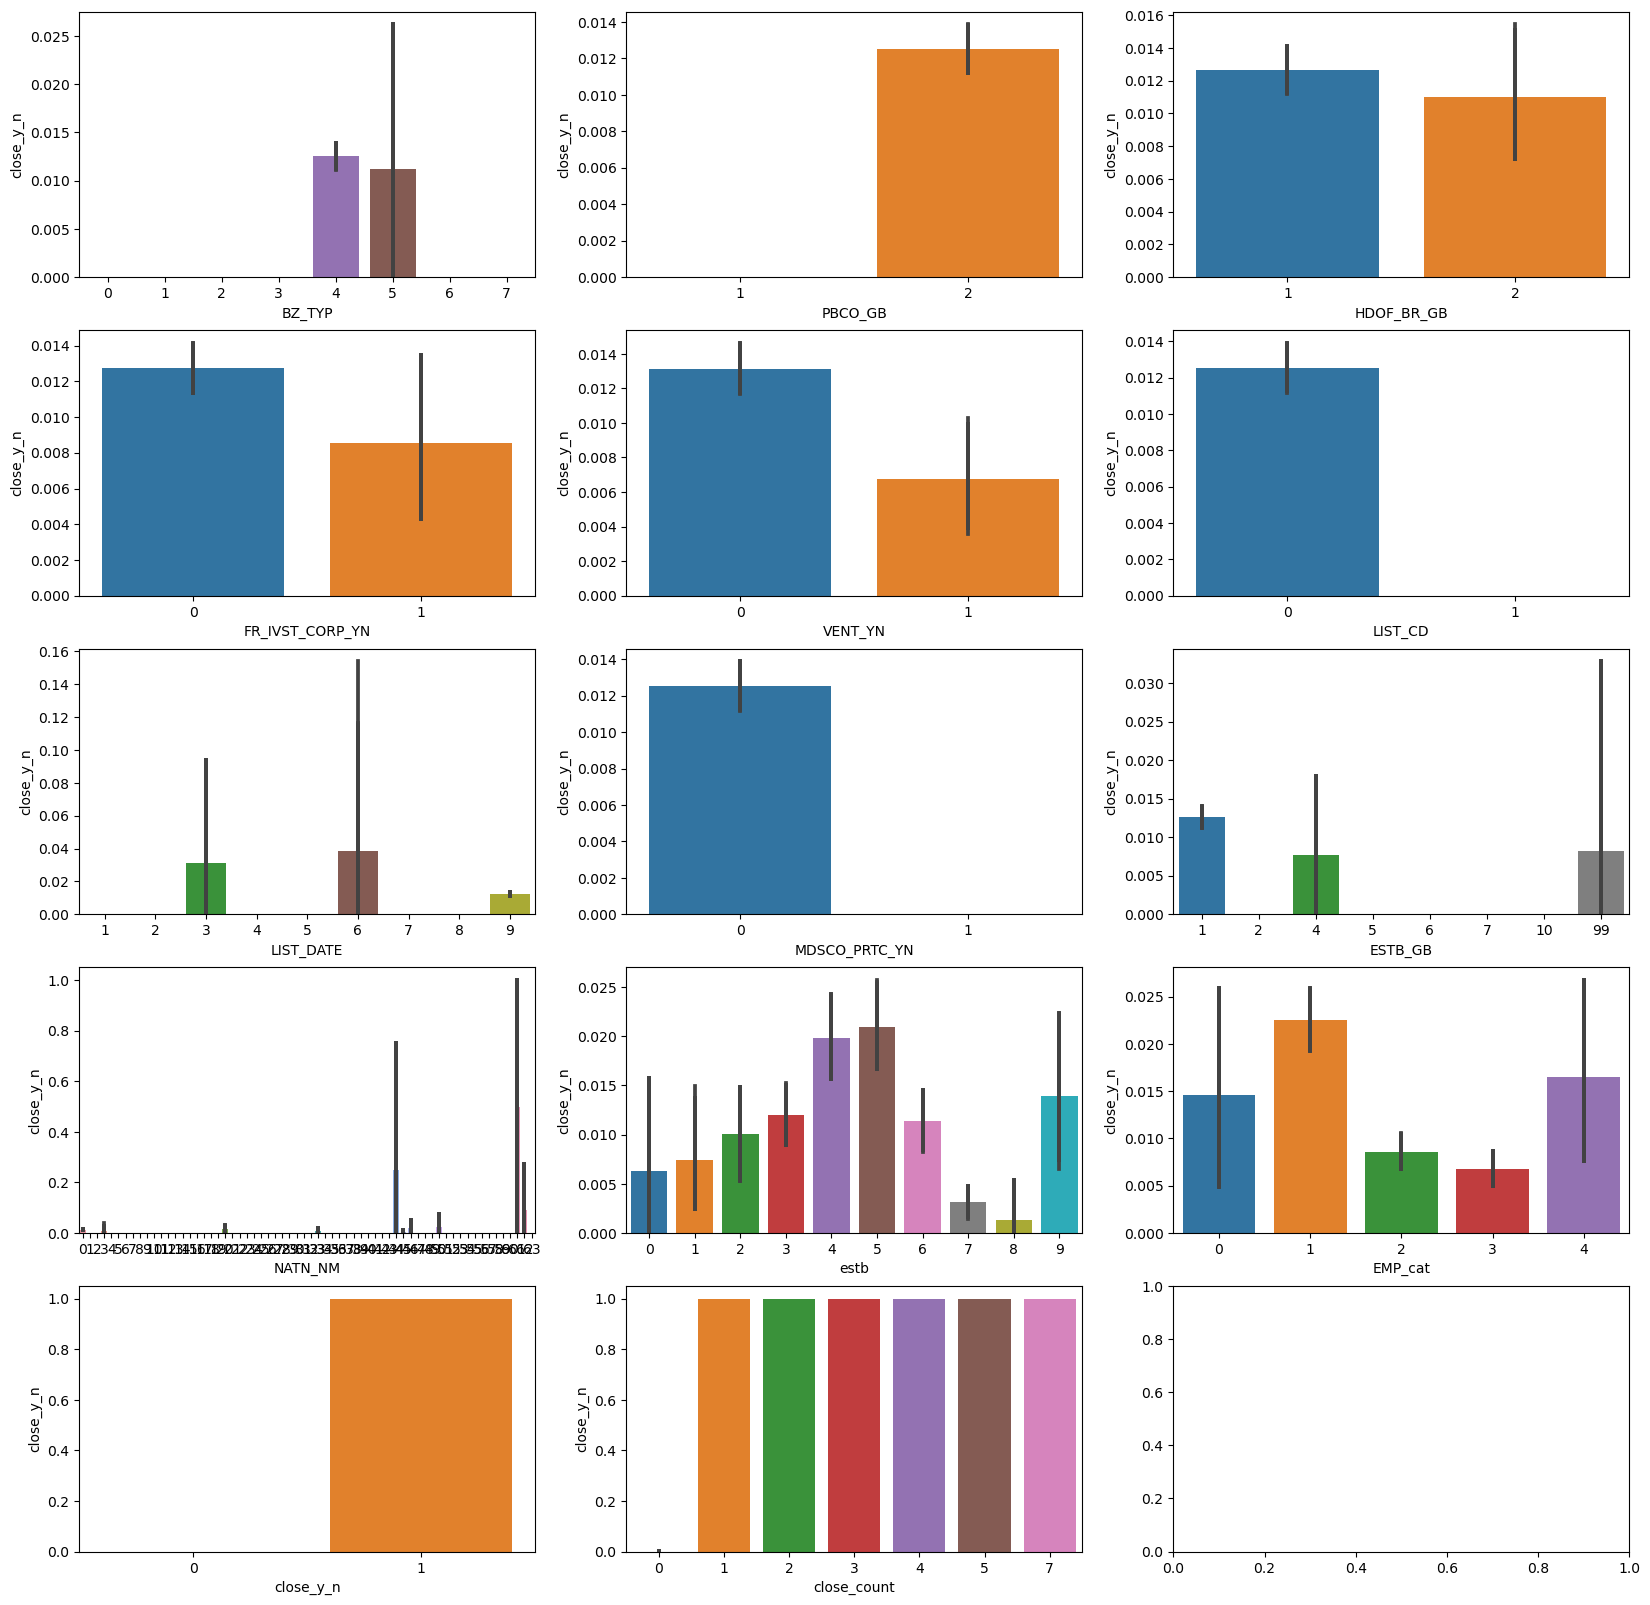

In [75]:
fig, axs = plt.subplots(figsize=(20,20), nrows=5, ncols=3)
for column in active_columns:
    sns.barplot(x=df_active_join['BZ_TYP'], y=df_active_join['close_y_n'], ax=axs[0][0])
    sns.barplot(x=df_active_join['PBCO_GB'], y=df_active_join['close_y_n'], ax=axs[0][1])
    sns.barplot(x=df_active_join['HDOF_BR_GB'], y=df_active_join['close_y_n'], ax=axs[0][2])
    sns.barplot(x=df_active_join['FR_IVST_CORP_YN'], y=df_active_join['close_y_n'], ax=axs[1][0])
    sns.barplot(x=df_active_join['VENT_YN'], y=df_active_join['close_y_n'], ax=axs[1][1])
    sns.barplot(x=df_active_join['LIST_CD'], y=df_active_join['close_y_n'], ax=axs[1][2])
    sns.barplot(x=df_active_join['LIST_DATE'], y=df_active_join['close_y_n'], ax=axs[2][0])
    sns.barplot(x=df_active_join['MDSCO_PRTC_YN'], y=df_active_join['close_y_n'], ax=axs[2][1])
    sns.barplot(x=df_active_join['ESTB_GB'], y=df_active_join['close_y_n'], ax=axs[2][2])
    sns.barplot(x=df_active_join['NATN_NM'], y=df_active_join['close_y_n'], ax=axs[3][0])
    sns.barplot(x=df_active_join['estb'], y=df_active_join['close_y_n'], ax=axs[3][1])
    sns.barplot(x=df_active_join['EMP_cat'], y=df_active_join['close_y_n'], ax=axs[3][2])
    sns.barplot(x=df_active_join['close_y_n'], y=df_active_join['close_y_n'], ax=axs[4][0])
    sns.barplot(x=df_active_join['close_count'], y=df_active_join['close_y_n'], ax=axs[4][1])



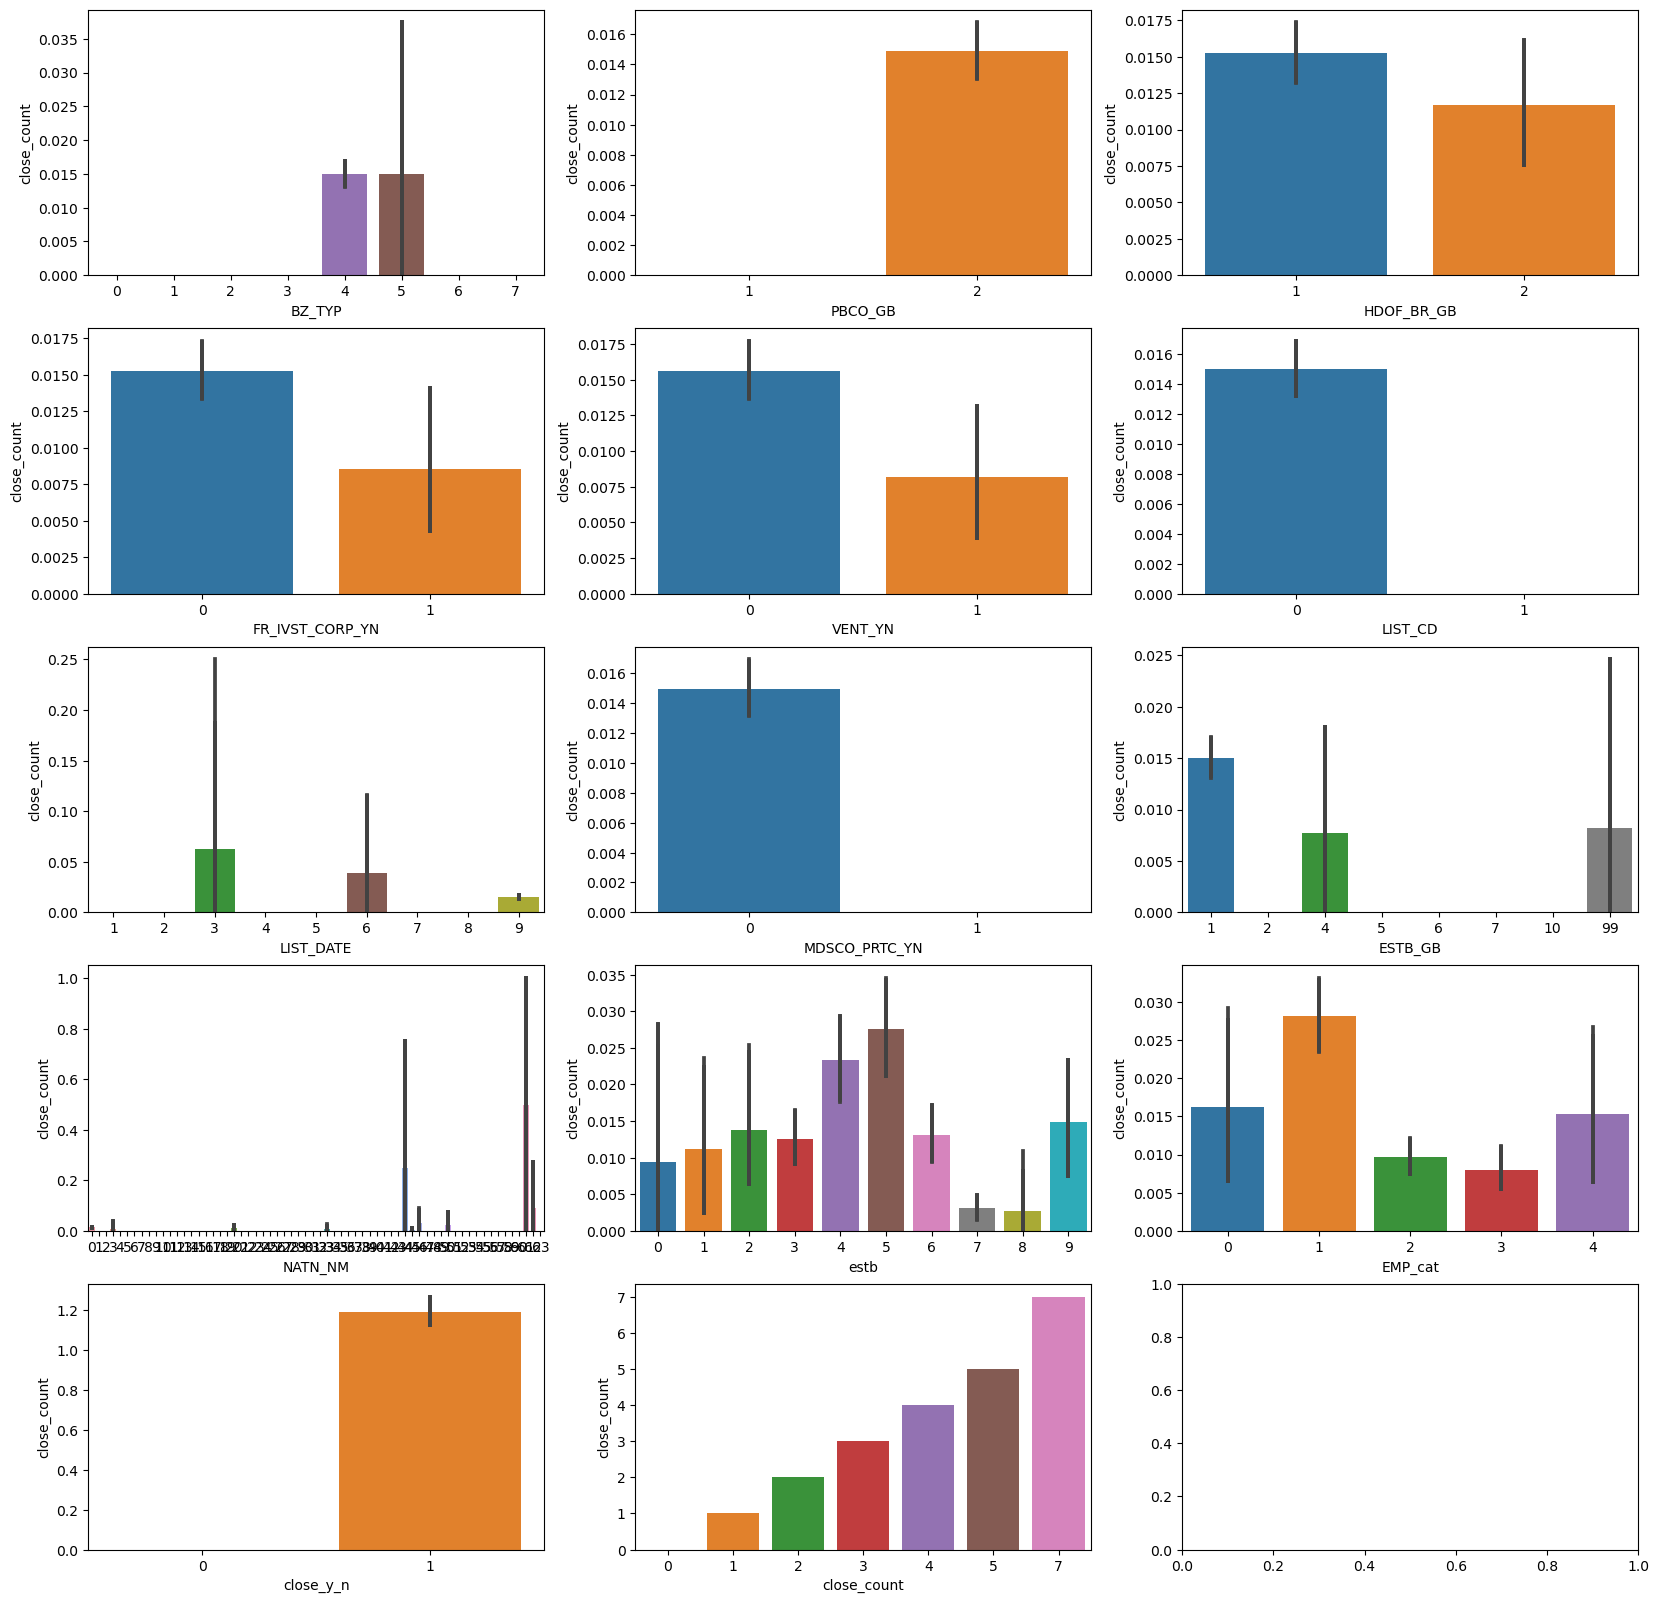

In [79]:
fig, axs = plt.subplots(figsize=(20,20), nrows=5, ncols=3)
for column in active_columns:
    sns.barplot(x=df_active_join['BZ_TYP'], y=df_active_join['close_count'], ax=axs[0][0])
    sns.barplot(x=df_active_join['PBCO_GB'], y=df_active_join['close_count'], ax=axs[0][1])
    sns.barplot(x=df_active_join['HDOF_BR_GB'], y=df_active_join['close_count'], ax=axs[0][2])
    sns.barplot(x=df_active_join['FR_IVST_CORP_YN'], y=df_active_join['close_count'], ax=axs[1][0])
    sns.barplot(x=df_active_join['VENT_YN'], y=df_active_join['close_count'], ax=axs[1][1])
    sns.barplot(x=df_active_join['LIST_CD'], y=df_active_join['close_count'], ax=axs[1][2])
    sns.barplot(x=df_active_join['LIST_DATE'], y=df_active_join['close_count'], ax=axs[2][0])
    sns.barplot(x=df_active_join['MDSCO_PRTC_YN'], y=df_active_join['close_count'], ax=axs[2][1])
    sns.barplot(x=df_active_join['ESTB_GB'], y=df_active_join['close_count'], ax=axs[2][2])
    sns.barplot(x=df_active_join['NATN_NM'], y=df_active_join['close_count'], ax=axs[3][0])
    sns.barplot(x=df_active_join['estb'], y=df_active_join['close_count'], ax=axs[3][1])
    sns.barplot(x=df_active_join['EMP_cat'], y=df_active_join['close_count'], ax=axs[3][2])
    sns.barplot(x=df_active_join['close_y_n'], y=df_active_join['close_count'], ax=axs[4][0])
    sns.barplot(x=df_active_join['close_count'], y=df_active_join['close_count'], ax=axs[4][1])



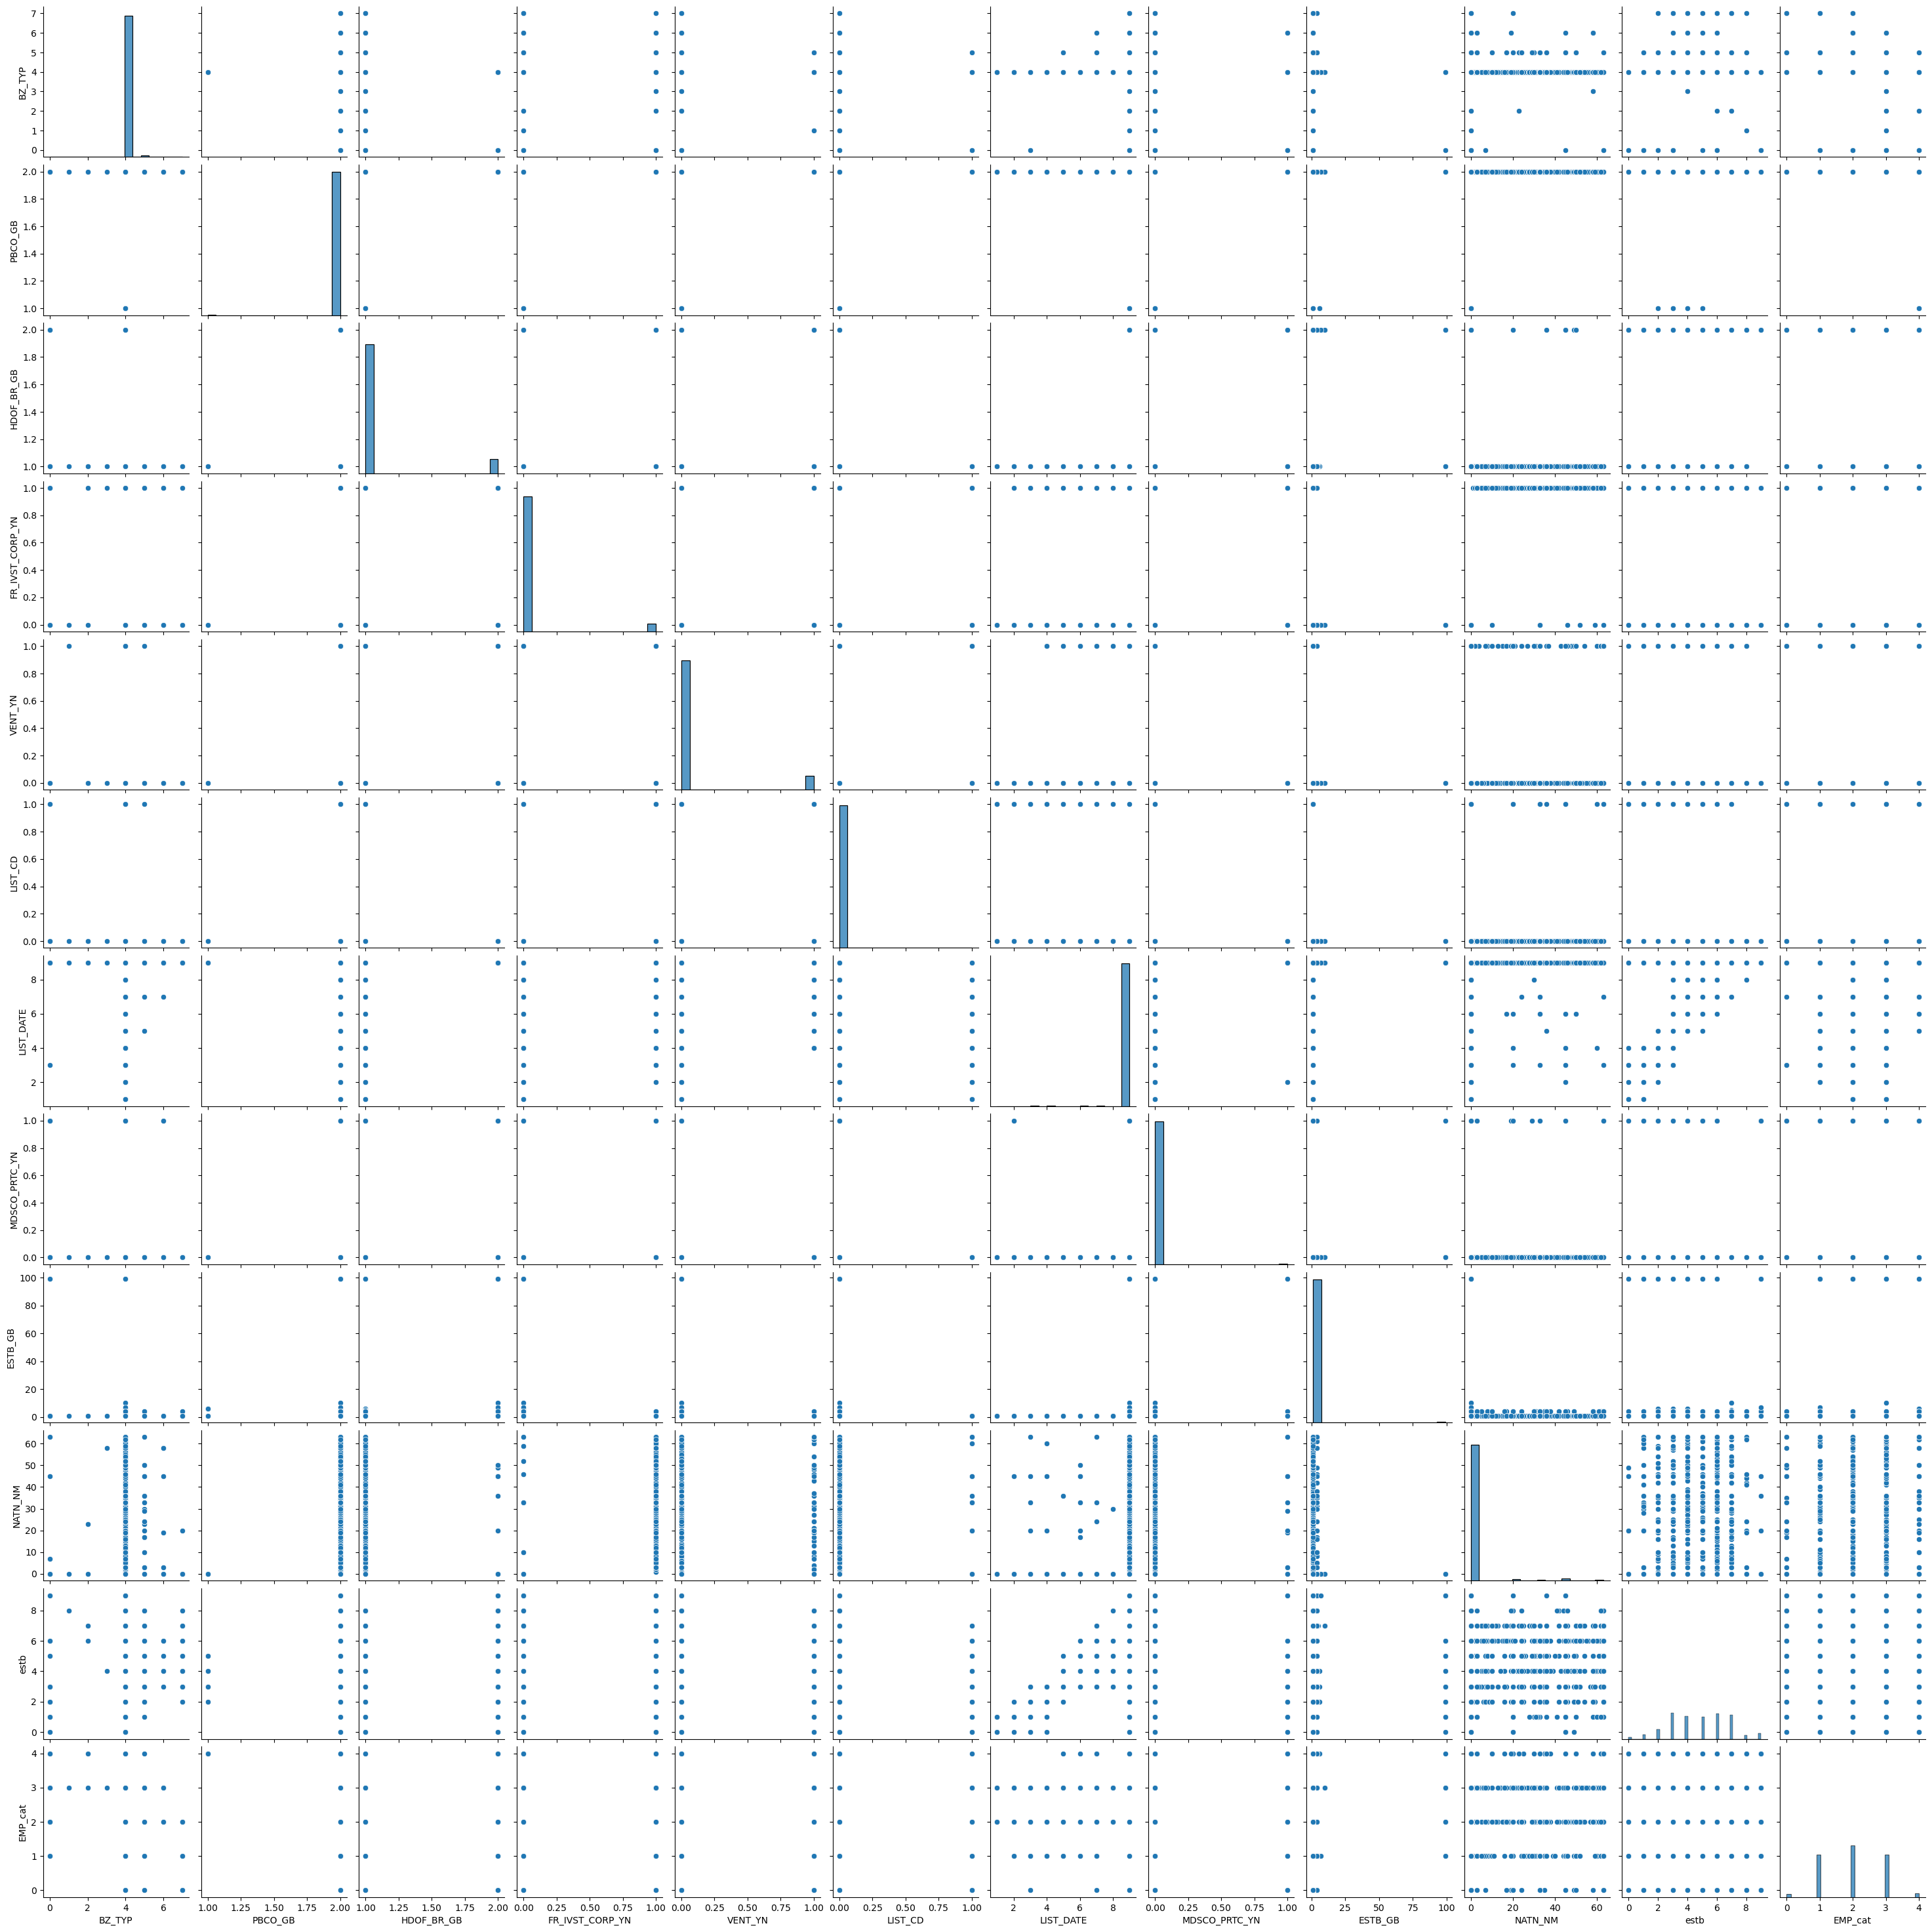

In [77]:
#pair plot도 그려보기
pair_columns = df_active_select.columns[1:]
fig = sns.pairplot(df_active_select[pair_columns])


<AxesSubplot:xlabel='BZ_TYP', ylabel='close_y_n'>

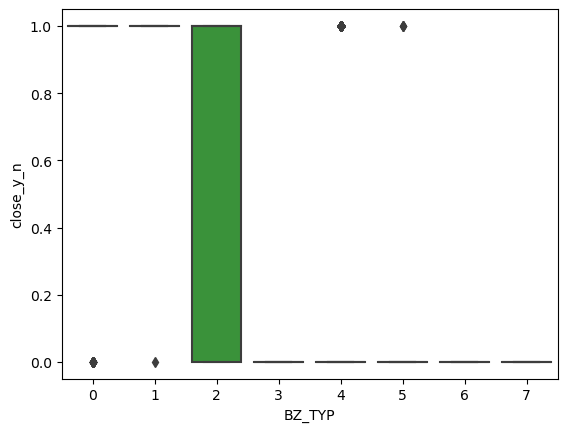

In [69]:
sns.boxplot(x=df_join['BZ_TYP'], y=df_join['close_y_n'])


# 머신러닝 

In [59]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

In [60]:
df_active_join.columns==df_inactive_join.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [61]:
# df_active_join과 df_inactive_join 합치기
df_join = pd.merge(df_active_join, df_inactive_join, how='outer')

c:\Users\bin\anaconda3\envs\numble\lib\site-packages\pandas\core\reshape\merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


In [70]:
features = [ 
 'PBCO_GB',
 'HDOF_BR_GB',
 'FR_IVST_CORP_YN',
 'VENT_YN',
 'LIST_CD',
 'LIST_DATE',
 'MDSCO_PRTC_YN',
 'ESTB_GB',
 'NATN_NM',
 'estb',
 'EMP_cat',]

In [71]:
#X, y 만들기
y_target = df_join['close_y_n']
X_features = df_join[features]

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

In [72]:
#성능 측정 함수 만들기
from sklearn.metrics import mean_absolute_error


def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE:{2:.3f}'.format(rmsle_val, rmse_val, mae_val))

In [73]:
#모델 만들기
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

#성능 측정
evaluate_regr(y_test, pred)

RMSLE: 0.267, RMSE: 0.379, MAE:0.291


### coef - lr_reg

<AxesSubplot:>

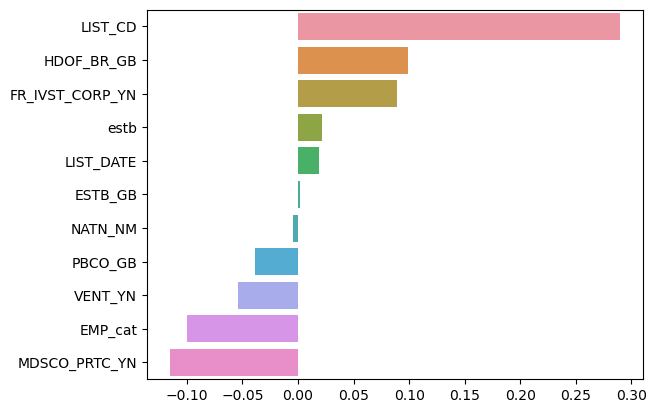

In [74]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

### feature_importances - Rf_reg
linear에는 feature_importances없는듯

In [109]:
#모델 만들기
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
rf_reg.fit(X_train, y_train)
pred = rf_reg.predict(X_test)

#성능 측정
evaluate_regr(y_test, pred)

RMSLE: 0.260, RMSE: 0.369, MAE:0.269


<AxesSubplot:>

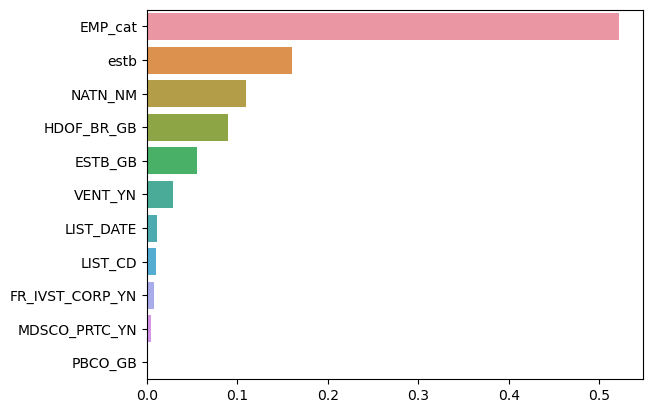

In [110]:
#시각화
feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_features.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

### 모델 여러가지 해보기

LinearRegression 선형회귀, 규제선형회귀(릿지,라쏘,엘라스틱넷)
LogisticRegression 로지스틱회귀
DecisionTreeRegressor
RandomForestRegresso 회귀트리
GradientBoostingRegressor
XGBRegressor
LGBMRegressor

In [79]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

In [96]:
lr_reg = LinearRegression()
dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
# xgb_reg = XGBRegressor(n_estimators=1000)
# lgb_reg = LGBMRegressor(n_estimators=1000)

In [87]:
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred) #원상태로 돌려줌
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

In [88]:
#훈련fit, 예측 predict

models = [lr_reg, dt_reg, rf_reg, gb_reg]
for model in models:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)
    



### LinearRegression ###
RMSLE: 0.379, RMSE: 0.661, MAE:0.444
### DecisionTreeRegressor ###
RMSLE: 0.375, RMSE: 0.654, MAE:0.432
### RandomForestRegressor ###
RMSLE: 0.369, RMSE: 0.643, MAE:0.417
### GradientBoostingRegressor ###
RMSLE: 0.368, RMSE: 0.643, MAE:0.418


#### lr_reg의 coef

In [111]:
lg_reg = LinearRegression()
get_model_predict(lg_reg, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.379, RMSE: 0.661, MAE:0.444


In [116]:
#lg_reg의 기울기
(lg_reg.coef_)

array([-0.03892985,  0.09898603,  0.08904268, -0.05426822,  0.29012204,
        0.01850366, -0.11566608,  0.00148789, -0.00431249,  0.02124529,
       -0.09975565])

In [131]:
coef = pd.DataFrame(lg_reg.coef_).T
coef.rename(columns=X_features.columns.tolist())

TypeError: 'list' object is not callable

#### lg_reg의 coef

In [99]:
C = [0.1,0.25,1]
penalty = ['l1','l2']
for c in C:
  for p in penalty:
    log_reg = LogisticRegression(C=c, penalty=p, solver='liblinear', max_iter=2000)
    print('C:',c, 'penalty:',p)
    get_model_predict(log_reg, X_train, X_test, y_train, y_test, is_expm1=True)

C: 0.1 penalty: l1
### LogisticRegression ###
RMSLE: 0.461, RMSE: 0.792, MAE:0.365
C: 0.1 penalty: l2
### LogisticRegression ###
RMSLE: 0.459, RMSE: 0.789, MAE:0.363
C: 0.25 penalty: l1
### LogisticRegression ###
RMSLE: 0.460, RMSE: 0.790, MAE:0.363
C: 0.25 penalty: l2
### LogisticRegression ###
RMSLE: 0.460, RMSE: 0.790, MAE:0.363
C: 1 penalty: l1
### LogisticRegression ###
RMSLE: 0.460, RMSE: 0.790, MAE:0.363
C: 1 penalty: l2
### LogisticRegression ###
RMSLE: 0.460, RMSE: 0.790, MAE:0.363


In [106]:
coef = pd.DataFrame(lg_reg.coef_, columns=X_features.columns)
# coef_sort = coef.sort_values(ascending=False)
coef

,PBCO_GB,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_CD,LIST_DATE,MDSCO_PRTC_YN,ESTB_GB,NATN_NM,estb,EMP_cat
0,-0.917701,0.518844,1.134624,-0.536382,1.709905,0.104194,-0.89557,0.006922,-0.065391,0.138062,-0.742004


coef는 linear, logistic밖에 없나
각 모델별로 언제 어떤 모델을 쓰는거?

df.corr로 상관관계보기

In [137]:
df_join.corr()

,BIZ_NO,BZ_TYP,PBCO_GB,HDOF_BR_GB,FR_IVST_CORP_YN,VENT_YN,LIST_DATE,MDSCO_PRTC_YN,ESTB_GB,NATN_NM,estb,EMP_cat,close_y_n,close_count
BIZ_NO,1.000000,-0.067494,0.004869,-0.001949,-0.065546,-0.024492,0.031944,-0.012175,-0.006064,-0.049838,0.251499,-0.152857,0.055686,0.050905
BZ_TYP,-0.067494,1.000000,-0.006636,-0.140560,0.064560,0.085577,-0.000685,0.006925,-0.055165,0.077685,-0.213116,0.268510,-0.959942,-0.928419
PBCO_GB,0.004869,-0.006636,1.000000,0.005232,0.003205,0.004273,-0.000955,0.000775,-0.004005,0.002834,0.009670,-0.033093,0.006973,0.006820
HDOF_BR_GB,-0.001949,-0.140560,0.005232,1.000000,-0.079668,-0.112835,0.024162,0.066009,0.168749,-0.070528,0.212634,-0.098328,0.134138,0.127733
FR_IVST_CORP_YN,-0.065546,0.064560,0.003205,-0.079668,1.000000,0.010323,-0.016378,0.015332,-0.008123,0.877753,-0.057475,0.111666,-0.063079,-0.062803
VENT_YN,-0.024492,0.085577,0.004273,-0.112835,0.010323,1.000000,-0.011899,-0.016886,-0.024279,0.014819,0.001875,0.195630,-0.088956,-0.086934
LIST_DATE,0.031944,-0.000685,-0.000955,0.024162,-0.016378,-0.011899,1.000000,-0.007268,0.002499,-0.018949,0.085714,-0.029531,0.001490,0.000911
MDSCO_PRTC_YN,-0.012175,0.006925,0.000775,0.066009,0.015332,-0.016886,-0.007268,1.000000,0.001941,0.010602,0.011179,0.005381,-0.013565,-0.013572
ESTB_GB,-0.006064,-0.055165,-0.004005,0.168749,-0.008123,-0.024279,0.002499,0.001941,1.000000,-0.010396,0.052893,-0.029515,0.052372,0.050886
NATN_NM,-0.049838,0.077685,0.002834,-0.070528,0.877753,0.014819,-0.018949,0.010602,-0.010396,1.000000,-0.045022,0.096155,-0.075757,-0.074425


<AxesSubplot:>

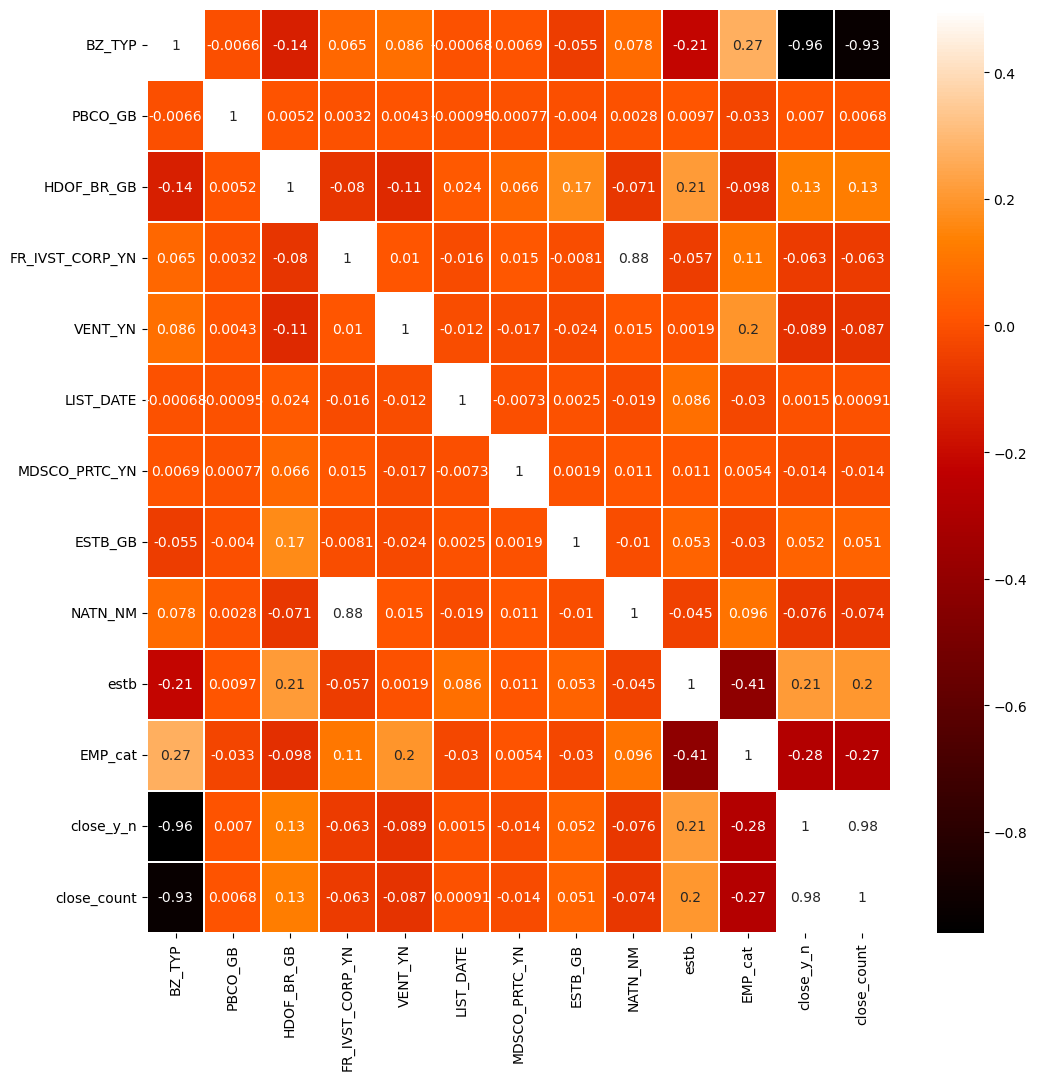

In [143]:

colormap = plt.cm.gist_heat
plt.figure(figsize=(12,12))
sns.heatmap(df_join.iloc[:, 1:].corr(), linewidths=0.1, vmax=0.5, cmap=colormap, linecolor='white', annot=True)

<AxesSubplot:>

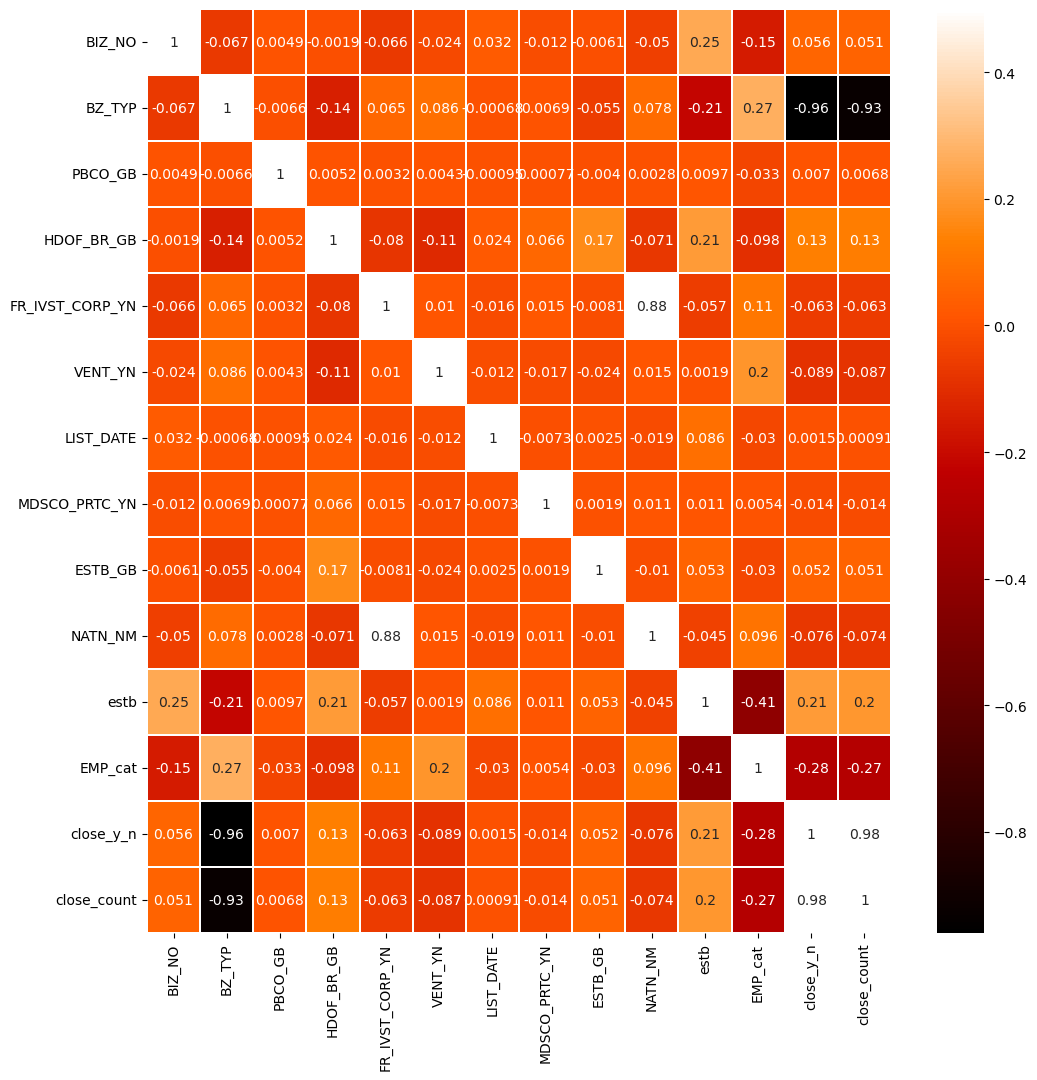

In [139]:
colormap = plt.cm.gist_heat
plt.figure(figsize=(12,12))
sns.heatmap(df_join.corr(), linewidths=0.1, vmax=0.5, cmap=colormap, linecolor='white', annot=True)